# Part I : Importing the data

In [1]:
# Here we import the librairies that we will use later

import keras
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split


np.random.seed(12345)
%matplotlib inline

C:\Users\Alexandre\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
# We import 2 .csv as dataframe

train_df = pd.read_csv('../data/fashion-mnist_train.csv')
test_df = pd.read_csv('../data/fashion-mnist_test.csv')

In [47]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# We create np.array because tensorflow use those

train_data = np.array(train_df, dtype ='float32')
test_data = np.array(test_df, dtype ='float32')

# Then we split (and rescale) our data sets

x_train = train_data[:, 1:] / 255   
y_train = train_data[:, 0]

x_test = test_data[:, 1:] / 255
y_test = test_data[:, 0]

In [12]:
# We create here a data set to train and one to validate

x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=12345 
)

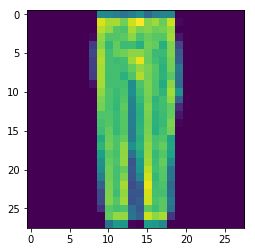

In [13]:
image = x_train[500, :].reshape(28,28)

plt.imshow(image)
plt.show()

# Part II : Create the CNN

In [14]:


im_rows =28
im_cols = 28
batch_size = 512
im_shape = (im_rows,im_cols, 1)

x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *im_shape)

In [15]:
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('x_validate shape: {}'.format(x_validate.shape))

x_train shape: (48000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_validate shape: (12000, 28, 28, 1)


In [16]:
# Define the model

cnn_model = Sequential([
    Conv2D(filters=32, kernel_size= (3,3), activation='relu', input_shape=im_shape),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [17]:
# Compile the model

cnn_model.compile(
    loss ='sparse_categorical_crossentropy',
    optimizer = Adam(lr=0.001),
    metrics = ['accuracy']
)

In [26]:
# Fit the model

cnn_model.fit(
    x_train, y_train, batch_size=batch_size,
    epochs =10, verbose= 2,
    validation_data=(x_test,y_test)
)

Train on 48000 samples, validate on 10000 samples
Epoch 1/10
 - 16s - loss: 0.2827 - acc: 0.9001 - val_loss: 0.2851 - val_acc: 0.9026
Epoch 2/10
 - 17s - loss: 0.2750 - acc: 0.9015 - val_loss: 0.2806 - val_acc: 0.9018
Epoch 3/10
 - 16s - loss: 0.2693 - acc: 0.9036 - val_loss: 0.2724 - val_acc: 0.9055
Epoch 4/10
 - 16s - loss: 0.2606 - acc: 0.9072 - val_loss: 0.2673 - val_acc: 0.9078
Epoch 5/10
 - 16s - loss: 0.2556 - acc: 0.9102 - val_loss: 0.2683 - val_acc: 0.9059
Epoch 6/10
 - 16s - loss: 0.2503 - acc: 0.9106 - val_loss: 0.2653 - val_acc: 0.9080
Epoch 7/10
 - 17s - loss: 0.2457 - acc: 0.9116 - val_loss: 0.2607 - val_acc: 0.9071
Epoch 8/10
 - 17s - loss: 0.2441 - acc: 0.9120 - val_loss: 0.2651 - val_acc: 0.9076
Epoch 9/10
 - 18s - loss: 0.2362 - acc: 0.9152 - val_loss: 0.2554 - val_acc: 0.9125
Epoch 10/10
 - 18s - loss: 0.2341 - acc: 0.9158 - val_loss: 0.2560 - val_acc: 0.9109


In [20]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)

print('test loss: {:.4f}'.format(score[0]))

print(' test acc: {:.4f}'.format(score[1]))

test loss: 0.2986
 test acc: 0.8959



# Part III : Hyperopt of keras

In [2]:
from hyperopt import Trials, STATUS_OK, tpe, rand
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

In [2]:
def load_fashion_mnist():
    from keras.datasets import fashion_mnist  # this requires keras>=2.0.9
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.)
    print('Fashion MNIST samples', x.shape)
    return x, y 

In [3]:
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    trainTotal = np.array(pd.read_csv('../data/fashion-mnist_train.csv'))
    testTotal = np.array(pd.read_csv('../data/fashion-mnist_test.csv'))
    (x_train, y_train) = trainTotal[:, 1:], trainTotal[:, 0]
    (x_test, y_test) = testTotal[:, 1:], testTotal[:, 0]
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    nb_classes = 10
    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    return x_train, y_train, x_test, y_test

In [4]:
data()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.00392157,
         0.        ],
        [0.        , 0.00392157, 0.01176471, ..., 0.        , 0.        ,
         0.     

In [4]:
def create_model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    if conditional({{choice(['three', 'four'])}}) == 'four':
        model.add(Dense(100))

        # We can also choose between complete sets of layers

        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    model.fit(x_train, y_train,
              batch_size={{choice([64, 128])}},
              epochs=20,
              verbose=1,
              validation_data=(x_test, y_test))
    score, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [5]:
# if __name__ == '__main__':
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      trials=Trials(),
                                      notebook_name='Keras optim')

X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    from keras.callbacks import TensorBoard
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe, rand
except:
    pass

try:
    from keras.datasets import mnist
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
  

Epoch 7/20
60000/60000 [==============================] - 14s 225us/step - loss: 1.3564 - acc: 0.4711 - val_loss: 0.7765 - val_acc: 0.6615
Epoch 8/20
60000/60000 [==============================] - 13s 213us/step - loss: 1.3421 - acc: 0.4813 - val_loss: 0.7473 - val_acc: 0.7089
Epoch 9/20
60000/60000 [==============================] - 13s 215us/step - loss: 1.3396 - acc: 0.4843 - val_loss: 0.7244 - val_acc: 0.7113
Epoch 10/20
60000/60000 [==============================] - 13s 225us/step - loss: 1.3251 - acc: 0.4886 - val_loss: 0.6994 - val_acc: 0.7422
Epoch 11/20
60000/60000 [==============================] - 15s 246us/step - loss: 1.3155 - acc: 0.4966 - val_loss: 0.7027 - val_acc: 0.7292
Epoch 12/20
60000/60000 [==============================] - 15s 249us/step - loss: 1.3097 - acc: 0.5016 - val_loss: 0.7038 - val_acc: 0.7311
Epoch 13/20
60000/60000 [==============================] - 14s 242us/step - loss: 1.3077 - acc: 0.5034 - val_loss: 0.7025 - val_acc: 0.7145
Epoch 14/20
60000/60000

60000/60000 [==============================] - 21s 345us/step - loss: 0.3419 - acc: 0.8747 - val_loss: 0.3878 - val_acc: 0.8656
Epoch 5/20
60000/60000 [==============================] - 21s 358us/step - loss: 0.3334 - acc: 0.8805 - val_loss: 0.4690 - val_acc: 0.8231 0.3314 - acc: 0.8 - ETA: 1s - loss: 0.3
Epoch 6/20
60000/60000 [==============================] - 22s 369us/step - loss: 0.3272 - acc: 0.8830 - val_loss: 0.3573 - val_acc: 0.8710
Epoch 7/20
60000/60000 [==============================] - 23s 390us/step - loss: 0.3224 - acc: 0.8850 - val_loss: 0.3406 - val_acc: 0.8832
Epoch 8/20
60000/60000 [==============================] - 23s 391us/step - loss: 0.3183 - acc: 0.8862 - val_loss: 0.3906 - val_acc: 0.8638
Epoch 9/20
60000/60000 [==============================] - 22s 360us/step - loss: 0.3176 - acc: 0.8881 - val_loss: 0.3303 - val_acc: 0.8854
Epoch 10/20
60000/60000 [==============================] - 20s 341us/step - loss: 0.3165 - acc: 0.8900 - val_loss: 0.3469 - val_acc: 0.88

60000/60000 [==============================] - 11s 184us/step - loss: 1.9359 - acc: 0.3064 - val_loss: 1.2570 - val_acc: 0.6503
Epoch 2/20
60000/60000 [==============================] - 11s 179us/step - loss: 1.2135 - acc: 0.5516 - val_loss: 0.8841 - val_acc: 0.6964
Epoch 3/20
60000/60000 [==============================] - 11s 182us/step - loss: 0.9796 - acc: 0.6309 - val_loss: 0.7671 - val_acc: 0.7250
Epoch 4/20
60000/60000 [==============================] - 11s 188us/step - loss: 0.8779 - acc: 0.6653 - val_loss: 0.7044 - val_acc: 0.7386
Epoch 5/20
60000/60000 [==============================] - 12s 192us/step - loss: 0.8161 - acc: 0.6897 - val_loss: 0.6731 - val_acc: 0.7462
Epoch 6/20
60000/60000 [==============================] - 12s 194us/step - loss: 0.7823 - acc: 0.7006 - val_loss: 0.6498 - val_acc: 0.7571
Epoch 7/20
60000/60000 [==============================] - 12s 193us/step - loss: 0.7553 - acc: 0.7127 - val_loss: 0.6345 - val_acc: 0.7636
Epoch 8/20
60000/60000 [==============

60000/60000 [==============================] - 80s 1ms/step - loss: 0.2391 - acc: 0.9093 - val_loss: 0.2793 - val_acc: 0.8986
Epoch 20/20
60000/60000 [==============================] - 80s 1ms/step - loss: 0.2360 - acc: 0.9104 - val_loss: 0.2678 - val_acc: 0.9025
Test accuracy: 0.9025
Evalutation of best performing model:
10000/10000 [==============================] - 8s 774us/step
[0.26776398167610166, 0.9025]
Best performing model chosen hyper-parameters:
{'Activation': 1, 'Dense': 2, 'Dropout': 0.4143619965361732, 'Dropout_1': 0.09225974322037533, 'add': 1, 'batch_size': 1, 'conditional': 0, 'optimizer': 1}


In [27]:
best_run

{'Activation': 1,
 'Dense': 0,
 'Dropout': 0.011725082462182734,
 'Dropout_1': 0.46207837014862785,
 'add': 1,
 'batch_size': 1,
 'conditional': 1,
 'optimizer': 1}

In [6]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=rand.suggest,
                                      max_evals=10,
                                      trials=Trials(),
                                      notebook_name='Keras optim')

X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    from keras.callbacks import TensorBoard
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe, rand
except:
    pass

try:
    from keras.datasets import mnist
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
  

Epoch 7/20
60000/60000 [==============================] - 16s 263us/step - loss: 1.3572 - acc: 0.4701 - val_loss: 0.7431 - val_acc: 0.7085
Epoch 8/20
60000/60000 [==============================] - 15s 254us/step - loss: 1.3419 - acc: 0.4756 - val_loss: 0.7209 - val_acc: 0.7206
Epoch 9/20
60000/60000 [==============================] - 16s 262us/step - loss: 1.3275 - acc: 0.4879 - val_loss: 0.7324 - val_acc: 0.7073
Epoch 10/20
60000/60000 [==============================] - 15s 257us/step - loss: 1.3225 - acc: 0.4913 - val_loss: 0.7227 - val_acc: 0.7277
Epoch 11/20
60000/60000 [==============================] - 15s 256us/step - loss: 1.3060 - acc: 0.4989 - val_loss: 0.6990 - val_acc: 0.7154
Epoch 12/20
60000/60000 [==============================] - 16s 264us/step - loss: 1.3049 - acc: 0.5007 - val_loss: 0.6866 - val_acc: 0.7206
Epoch 13/20
60000/60000 [==============================] - 16s 263us/step - loss: 1.3079 - acc: 0.5009 - val_loss: 0.6947 - val_acc: 0.7202
Epoch 14/20
60000/60000

60000/60000 [==============================] - 25s 423us/step - loss: 0.3438 - acc: 0.8755 - val_loss: 0.3364 - val_acc: 0.8774
Epoch 5/20
60000/60000 [==============================] - 26s 426us/step - loss: 0.3342 - acc: 0.8798 - val_loss: 0.3621 - val_acc: 0.8655
Epoch 6/20
60000/60000 [==============================] - 26s 435us/step - loss: 0.3275 - acc: 0.8823 - val_loss: 0.3800 - val_acc: 0.8672
Epoch 7/20
60000/60000 [==============================] - 25s 410us/step - loss: 0.3226 - acc: 0.8835 - val_loss: 0.3909 - val_acc: 0.8736
Epoch 8/20
60000/60000 [==============================] - 25s 421us/step - loss: 0.3208 - acc: 0.8863 - val_loss: 0.3959 - val_acc: 0.8746
Epoch 9/20
60000/60000 [==============================] - 24s 402us/step - loss: 0.3170 - acc: 0.8889 - val_loss: 0.3877 - val_acc: 0.8699
Epoch 10/20
60000/60000 [==============================] - 26s 436us/step - loss: 0.3140 - acc: 0.8894 - val_loss: 0.4106 - val_acc: 0.8793
Epoch 11/20
60000/60000 [============

60000/60000 [==============================] - 14s 226us/step - loss: 1.9315 - acc: 0.2959 - val_loss: 1.2389 - val_acc: 0.6340
Epoch 2/20
60000/60000 [==============================] - 12s 202us/step - loss: 1.2197 - acc: 0.5397 - val_loss: 0.8891 - val_acc: 0.6995
Epoch 3/20
60000/60000 [==============================] - 12s 198us/step - loss: 0.9914 - acc: 0.6231 - val_loss: 0.7726 - val_acc: 0.7172
Epoch 4/20
60000/60000 [==============================] - 12s 203us/step - loss: 0.8836 - acc: 0.6624 - val_loss: 0.7155 - val_acc: 0.7406
Epoch 5/20
60000/60000 [==============================] - 14s 228us/step - loss: 0.8247 - acc: 0.6835 - val_loss: 0.6718 - val_acc: 0.7481
Epoch 6/20
60000/60000 [==============================] - 14s 227us/step - loss: 0.7857 - acc: 0.7002 - val_loss: 0.6500 - val_acc: 0.7503
Epoch 7/20
60000/60000 [==============================] - 14s 231us/step - loss: 0.7560 - acc: 0.7109 - val_loss: 0.6255 - val_acc: 0.7668
Epoch 8/20
60000/60000 [==============

Epoch 19/20
60000/60000 [==============================] - 18s 299us/step - loss: 0.2394 - acc: 0.9089 - val_loss: 0.2726 - val_acc: 0.8999
Epoch 20/20
60000/60000 [==============================] - 18s 292us/step - loss: 0.2344 - acc: 0.9106 - val_loss: 0.2692 - val_acc: 0.9018
Test accuracy: 0.9018
Evalutation of best performing model:
10000/10000 [==============================] - 2s 157us/step
[0.269217800784111, 0.9018]
Best performing model chosen hyper-parameters:
{'Activation': 1, 'Dense': 2, 'Dropout': 0.4143619965361732, 'Dropout_1': 0.09225974322037533, 'add': 1, 'batch_size': 1, 'conditional': 0, 'optimizer': 1}


NameError: name 'trial' is not defined